In [1]:
import torch

/home/ec249/ec249/bet20/miniconda3/envs/graph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)
print(torch.version.cuda)


"""
python -m pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.1+cu117.html
"""

2.0.1+cu117
11.7


'\npython -m pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.1+cu117.html\n'

In [4]:
import pytorch_lightning as pl

print(pl.__version__)

2.1.3


In [3]:
import torch_geometric as pyg

In [ ]:
forcing_features = torch.Tensor()

In [6]:
import torch

# Define the dimensions
B = 3  # Batch size
pred_steps = 4
N_grid = 5
d_static_f = 2

# Create a random tensor with the specified shape
forcing_features = torch.rand((B, pred_steps, N_grid, d_static_f))

# Print the created tensor
print(forcing_features)


tensor([[[[0.2073, 0.9328],
          [0.0552, 0.0168],
          [0.4485, 0.4042],
          [0.6726, 0.8975],
          [0.7965, 0.6579]],

         [[0.1493, 0.5579],
          [0.8077, 0.4184],
          [0.1707, 0.4574],
          [0.2736, 0.9490],
          [0.1274, 0.1470]],

         [[0.3195, 0.2642],
          [0.3741, 0.0540],
          [0.0459, 0.7240],
          [0.0199, 0.2304],
          [0.8819, 0.9447]],

         [[0.5381, 0.9773],
          [0.3556, 0.6832],
          [0.6837, 0.1063],
          [0.4686, 0.1840],
          [0.7881, 0.6901]]],


        [[[0.2895, 0.4023],
          [0.2026, 0.9206],
          [0.0335, 0.1871],
          [0.4629, 0.8396],
          [0.5807, 0.8292]],

         [[0.4396, 0.9451],
          [0.5021, 0.2842],
          [0.8192, 0.7179],
          [0.2106, 0.2227],
          [0.4139, 0.7533]],

         [[0.9342, 0.6943],
          [0.0597, 0.4271],
          [0.3841, 0.3039],
          [0.1548, 0.0843],
          [0.6821, 0.0592]],

    

In [8]:
pred_steps = forcing_features.shape[1]
pred_steps

4

In [16]:
forcing = forcing_features[:, 1, :, :]
print(forcing)
print(forcing.shape)

tensor([[[0.1493, 0.5579],
         [0.8077, 0.4184],
         [0.1707, 0.4574],
         [0.2736, 0.9490],
         [0.1274, 0.1470]],

        [[0.4396, 0.9451],
         [0.5021, 0.2842],
         [0.8192, 0.7179],
         [0.2106, 0.2227],
         [0.4139, 0.7533]],

        [[0.0646, 0.9978],
         [0.8535, 0.4639],
         [0.3927, 0.1582],
         [0.6122, 0.8058],
         [0.3176, 0.8671]]])
torch.Size([3, 5, 2])


In [2]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.empty(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        # Diagonal of degree matrix (all elements not on diagonal are 0)
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        
        # Elementwise multiplication
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        # calculate message by passing x, norm to self.message() (internally)
        # for each node, use edge_index to determine incoming messages
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # calculates the message for node i (that is, x_i)
        # x_j has shape [E, out_channels]
        # x_j is the node feature matrix of the neighbors of node i
        # Step 4: Normalize node features.
        print("x_j.shape")
        print(x_j.shape)
        return norm.view(-1, 1) * x_j
    
    def update(self, aggr_out, x):
        print("aggr_out.shape")
        print(aggr_out.shape)
        print("x.shape")
        print(x.shape)
        return aggr_out + x

In [4]:
# Create an instance of GCNConv
gcn = GCNConv(in_channels=64, out_channels=128)

# Create sample input data
x = torch.randn(10, 64)  # Node feature matrix
edge_index = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
                           [1, 0, 3, 2, 5, 4, 7, 6, 9, 8]])  # Edge indices

# Pass the input data through GCNConv
output = gcn(x, edge_index)

# Print the output
print(output)
print(output.shape)

x_j.shape
torch.Size([20, 128])
aggr_out.shape
torch.Size([10, 128])
x.shape
torch.Size([10, 128])
tensor([[-1.6726,  0.7789,  0.2470,  ...,  0.8314,  0.1620, -0.6875],
        [-1.4641,  0.7125,  0.5356,  ..., -0.3258, -1.4977, -0.9814],
        [-0.3235, -0.3885,  2.7501,  ...,  2.8464,  0.5815, -0.6574],
        ...,
        [-0.3898, -0.1143, -0.4869,  ..., -0.0704,  0.3540, -0.3842],
        [ 1.2987,  0.6214, -1.4607,  ...,  0.4991,  1.9813, -0.2139],
        [ 0.4233,  2.5467, -1.2930,  ...,  1.2293,  0.1719, -0.5277]],
       grad_fn=<AddBackward0>)
torch.Size([10, 128])


In [5]:
x = torch.randn(10, 128)  # Node feature matrix
_edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
print(_edge_index)
print(_edge_index.shape)

row, col = _edge_index
# Diagonal of degree matrix
deg = degree(col, x.size(0), dtype=x.dtype)
print(deg)

deg_inv_sqrt = deg.pow(-0.5)
deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
print(deg_inv_sqrt[row])
print(deg_inv_sqrt[col])
print(norm)
print(norm.shape)

print(norm.view(-1, 1))

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [1, 0, 3, 2, 5, 4, 7, 6, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
torch.Size([2, 20])
tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])
tensor([0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071])
tensor([0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071, 0.7071,
        0.7071, 0.7071])
tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000, 0.5000])
torch.Size([20])
tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
  

In [29]:
import matplotlib.pyplot as plt
import numpy as np

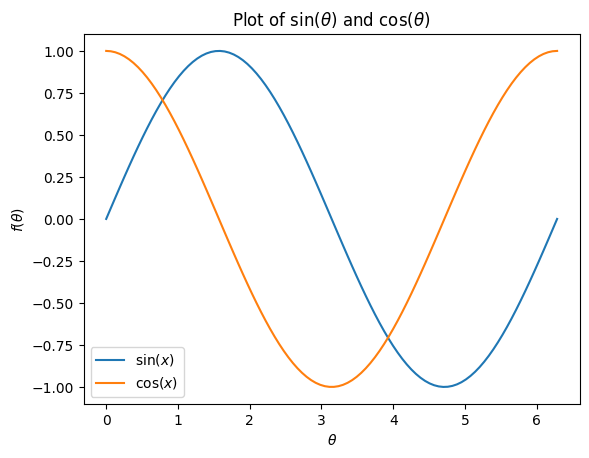

In [31]:

# Generate data
x = np.linspace(0, 2 * np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)

# Create a plot with multiple curves
plt.plot(x, y1, label=r'$\sin(x)$')
plt.plot(x, y2, label=r'$\cos(x)$')

# Add labels and title with complex LaTeX formatting
plt.xlabel(r'$\theta$')
plt.ylabel(r'$f(\theta)$')
plt.title(r'Plot of $\sin(\theta)$ and $\cos(\theta)$')

# Add a legend
plt.legend()

# Display the plot
plt.show()


In [8]:
# Create two tensors of shape (3, 2)
tensor1 = torch.tensor([[1, 2], [3, 4], [5, 6]])
tensor2 = torch.tensor([[7, 8], [9, 10], [11, 12]])

print("Tensor 1:", tensor1)
print("Tensor 2:", tensor2)

# Concatenate along dim=1 (columns)
concat_dim1 = torch.cat((tensor1, tensor2), dim=0)
print("Concatenation along dim=1:")
print(concat_dim1)

# Concatenate along dim=-1 (also columns, since -1 refers to the last dimension)
concat_dim_minus1 = torch.cat((tensor1, tensor2), dim=-1)
print("Concatenation along dim=-1:")
print(concat_dim_minus1)

Tensor 1: tensor([[1, 2],
        [3, 4],
        [5, 6]])
Tensor 2: tensor([[ 7,  8],
        [ 9, 10],
        [11, 12]])
Concatenation along dim=1:
tensor([[ 1,  2],
        [ 3,  4],
        [ 5,  6],
        [ 7,  8],
        [ 9, 10],
        [11, 12]])
Concatenation along dim=-1:
tensor([[ 1,  2,  7,  8],
        [ 3,  4,  9, 10],
        [ 5,  6, 11, 12]])


In [4]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='/tmp/Cora', name='Cora')

Processing...
Done!


In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, MessagePassing

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    
# class MyGCNLayer()
    
class MyGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [6]:
model = GCN()
data = dataset[0]
out = model(data)

out

tensor([[-1.9817, -1.9444, -1.8894,  ..., -1.9485, -1.8887, -1.9793],
        [-1.9635, -1.8561, -1.9005,  ..., -1.8483, -1.9641, -2.0171],
        [-1.9568, -1.8734, -1.9262,  ..., -1.8644, -1.9764, -1.9931],
        ...,
        [-1.9272, -2.0221, -1.8778,  ..., -1.9461, -1.9262, -1.9260],
        [-1.9655, -1.8769, -1.9582,  ..., -1.9549, -1.8858, -2.0054],
        [-1.9539, -1.9086, -1.9447,  ..., -1.9528, -1.9099, -1.9771]],
       grad_fn=<LogSoftmaxBackward0>)

In [9]:
from torchsummary import summary

In [7]:
model = GCN()
total_params = sum(p.numel() for p in model.parameters())

In [8]:
total_params

23063

In [10]:
summary(model, (1433, 2708))

AttributeError: 'Tensor' object has no attribute 'x'

In [ ]:
import networkx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from argparse import ArgumentParser
import scipy.spatial
import torch
import torch_geometric as pyg
import os
from torch_geometric.utils.convert import from_networkx

static_dir_path = os.path.join("data", args.dataset, "static")
graph_dir_path = os.path.join("graphs", args.graph)
os.makedirs(graph_dir_path, exist_ok=True)

xy = np.load(os.path.join(static_dir_path, "nwp_xy.npy"))

In [1]:
import os
import glob
import torch
import numpy as np
import datetime as dt

In [1]:
import random

r = random.randint(0, 4)

for _ in range(10):
    print(random.randint(0, 4))

1
0
1
4
0
0
0
1
1
2


In [13]:
import random
import torch
import pytorch_lightning as pl
from lightning_fabric.utilities import seed
from argparse import ArgumentParser
import time
import os

import torch_geometric as pyg

from neural_lam.models.graph_lam import GraphLAM
from neural_lam.models.hi_lam import HiLAM
from neural_lam.models.hi_lam_parallel import HiLAMParallel
from neural_lam.models.gcn_model import GCNModel
from neural_lam.models.gat_model import GATModel

from neural_lam.weather_dataset import WeatherDataset
from neural_lam import constants, utils

# Required for running jobs on GPU node
os.environ["WANDB_CONFIG_DIR"] = "/work/ec249/ec249/bet20/.config/wandb"

MODELS = {
    "graph_lam": GraphLAM,
    "hi_lam": HiLAM,
    "hi_lam_parallel": HiLAMParallel,
    "gcn": GCNModel,
    "gat": GATModel,
}

def get_args():
    parser = ArgumentParser(description='Train or evaluate NeurWP models for LAM')

    # General options
    parser.add_argument('--dataset', type=str, default="meps_example",
        help='Dataset, corresponding to name in data directory (default: meps_example)')
    parser.add_argument('--model', type=str, default="graph_lam",
        help='Model architecture to train/evaluate (default: graph_lam)')
    parser.add_argument('--subset_ds', type=int, default=0,
        help='Use only a small subset of the dataset, for debugging (default: 0=false)')
    parser.add_argument('--seed', type=int, default=42,
        help='random seed (default: 42)')
    parser.add_argument('--n_workers', type=int, default=4,
        help='Number of workers in data loader (default: 4)')
    parser.add_argument('--epochs', type=int, default=200,
        help='upper epoch limit (default: 200)')
    parser.add_argument('--batch_size', type=int, default=4,
        help='batch size (default: 4)')
    parser.add_argument('--load', type=str,
        help='Path to load model parameters from (default: None)')
    parser.add_argument('--restore_opt', type=int, default=0,
        help='If optimizer state shoudl be restored with model (default: 0 (false))')
    parser.add_argument('--precision', type=str, default=32,
        help='Numerical precision to use for model (32/16/bf16) (default: 32)')

    # Model architecture
    parser.add_argument('--graph', type=str, default="multiscale",
        help='Graph to load and use in graph-based model (default: multiscale)')
    parser.add_argument('--hidden_dim', type=int, default=64,
        help='Dimensionality of all hidden representations (default: 64)')
    parser.add_argument('--hidden_layers', type=int, default=1,
        help='Number of hidden layers in all MLPs (default: 1)')
    parser.add_argument('--processor_layers', type=int, default=4,
        help='Number of GNN layers in processor GNN (default: 4)')
    parser.add_argument('--mesh_aggr', type=str, default="sum",
        help='Aggregation to use for m2m processor GNN layers (sum/mean) (default: sum)')

    # Training options
    parser.add_argument('--ar_steps', type=int, default=1,
        help='Number of steps to unroll prediction for in loss (1-19) (default: 1)')
    parser.add_argument('--control_only', type=int, default=0,
        help='Train only on control member of ensemble data (default: 0 (False))')
    parser.add_argument('--loss', type=str, default="mse",
        help='Loss function to use (default: mse)')
    parser.add_argument('--step_length', type=int, default=3,
        help='Step length in hours to consider single time step 1-3 (default: 3)')
    parser.add_argument('--lr', type=float, default=1e-3,
        help='learning rate (default: 0.001)')
    parser.add_argument('--val_interval', type=int, default=1,
        help='Number of epochs training between each validation run (default: 1)')

    # Evaluation options
    parser.add_argument('--eval', type=str,
        help='Eval model on given data split (val/test) (default: None (train model))')
    parser.add_argument('--n_example_pred', type=int, default=1,
        help='Number of example predictions to plot during evaluation (default: 1)')
    args = parser.parse_known_args()
    print(args)
    
    args = args[0]

    # Asserts for arguments
    assert args.model in MODELS, f"Unknown model: {args.model}"
    assert args.step_length <= 3, "Too high step length"
    assert args.eval in (None, "val", "test"), f"Unknown eval setting: {args.eval}"
    
    return args

def main():
    args = get_args() 
    # Get an (actual) random run id as a unique identifier
    random_run_id = random.randint(0, 9999)

    # Set seed
    seed.seed_everything(args.seed)

    # Load data
    # train_loader = torch.utils.data.DataLoader(
    train_loader = pyg.loader.DataLoader(
            WeatherDataset(
                args.dataset, pred_length=args.ar_steps, split="train",
                subsample_step=args.step_length, subset=bool(args.subset_ds),
                control_only=args.control_only),
            args.batch_size, shuffle=True, num_workers=args.n_workers)
    
    _train_loader = torch.utils.data.DataLoader(
            WeatherDataset(
                args.dataset, pred_length=args.ar_steps, split="train",
                subsample_step=args.step_length, subset=bool(args.subset_ds),
                control_only=args.control_only),
            args.batch_size, shuffle=True, num_workers=args.n_workers)

In [14]:
args = get_args() 
# Get an (actual) random run id as a unique identifier
random_run_id = random.randint(0, 9999)

# Set seed
seed.seed_everything(args.seed)

# Load data
# train_loader = torch.utils.data.DataLoader(
train_loader = pyg.loader.DataLoader(
        WeatherDataset(
            args.dataset, pred_length=args.ar_steps, split="train",
            subsample_step=args.step_length, subset=bool(args.subset_ds),
            control_only=args.control_only),
        args.batch_size, shuffle=True, num_workers=args.n_workers)

_train_loader = torch.utils.data.DataLoader(
        WeatherDataset(
            args.dataset, pred_length=args.ar_steps, split="train",
            subsample_step=args.step_length, subset=bool(args.subset_ds),
            control_only=args.control_only),
        args.batch_size, shuffle=True, num_workers=args.n_workers)

Seed set to 42


(Namespace(dataset='meps_example', model='graph_lam', subset_ds=0, seed=42, n_workers=4, epochs=200, batch_size=4, load=None, restore_opt=0, precision=32, graph='multiscale', hidden_dim=64, hidden_layers=1, processor_layers=4, mesh_aggr='sum', ar_steps=1, control_only=0, loss='mse', step_length=3, lr=0.001, val_interval=1, eval=None, n_example_pred=1), ['--f=/home/ec249/ec249/bet20/.local/share/jupyter/runtime/kernel-v2-2715940MDsDcFYO90E7.json'])


In [15]:
batch = next(iter(train_loader))

batch

[tensor([[[[  0.5905,   0.3072,  -9.3784,  ...,   0.7652,   0.3488,   0.5860],
           [  0.5708,   0.2327,  -9.1929,  ...,   0.8077,   0.2928,   0.5229],
           [  0.5505,   0.1978,  -9.1671,  ...,   0.8002,   0.2413,   0.4957],
           ...,
           [ -1.6278,  -1.8812,  -7.0008,  ...,  -0.6392,  -1.8694,  -1.8600],
           [ -1.1297,  -1.8723,  -7.1282,  ...,  -0.5700,  -1.8791,  -1.8622],
           [ -1.0482,  -1.9241,  -7.1505,  ...,  -0.5596,  -1.8231,  -1.8124]],
 
          [[  0.6466,   0.4870,  -9.5760,  ...,   0.6107,   0.5314,   0.7626],
           [  0.6309,   0.4244,  -9.4844,  ...,   0.6547,   0.4932,   0.7110],
           [  0.6133,   0.3992,  -9.4304,  ...,   0.6834,   0.4511,   0.6896],
           ...,
           [ -1.5658,  -1.6781,  -7.2143,  ...,  -0.6277,  -1.6747,  -1.7936],
           [ -1.0655,  -1.6639,  -7.4349,  ...,  -0.5550,  -1.6798,  -1.7961],
           [ -0.9823,  -1.7122,  -7.3610,  ...,  -0.5431,  -1.6236,  -1.7474]]],
 
 
         [[

In [16]:
type(batch)

list

In [2]:
import torch
from torch_geometric.data import Data

In [9]:
edge_index = torch.tensor([[0, 1, 1, 2, 3],
                           [1, 0, 2, 1, 2]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1], [2]], dtype=torch.float)

# data = Data(x=x, edge_index=edge_index)
data = Data(x=x)

In [10]:
data.validate()

True

In [12]:
data.num_nodes
# data.num_edges

4

In [1]:
from torch_geometric.utils import scatter
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

Extracting /tmp/ENZYMES/ENZYMES/ENZYMES.zip
Processing...
Done!


In [3]:
data = dataset[0]
data

Data(edge_index=[2, 168], x=[37, 21], y=[1])

In [18]:
btch = next(iter(loader))

In [19]:
btch

DataBatch(edge_index=[2, 4020], x=[1015, 21], y=[32], batch=[1015], ptr=[33])